[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
                   MAE          RMSE
LSTM        695.037543    843.292056
LSTM+CNN   2090.119758   2744.069905
XGBoost   13936.326995  18741.404229


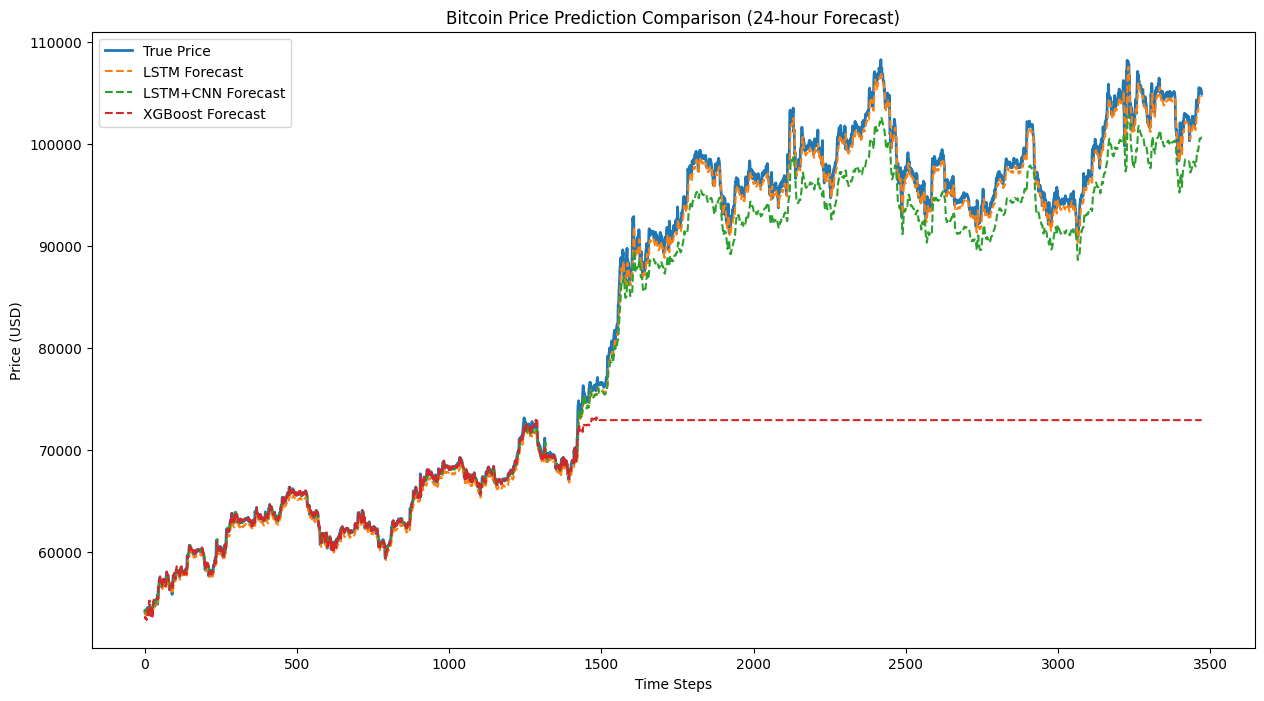

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from xgboost import XGBRegressor
from prophet import Prophet

# Download Bitcoin data
data = yf.download('BTC-USD', period='2y', interval='1h')
data = data[['Close']].rename(columns={'Close': 'price'})
data = data.ffill()

# Parameters
sequence_length = 72  # Use 72 hours (3 days) of history
n_steps = 24          # Predict 24 hours ahead
test_size = 0.2

# Scale data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences for LSTM/CNN models
def create_sequences(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data)-seq_length-pred_length+1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, sequence_length, n_steps)
split_idx = int(len(X)*(1-test_size))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# LSTM Model
lstm_model = Sequential([
    LSTM(100, activation='relu', input_shape=(sequence_length, 1)),
    Dense(n_steps)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
lstm_pred = lstm_model.predict(X_test)

# LSTM+CNN Model
cnn_lstm_model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(sequence_length, 1)),
    MaxPooling1D(2),
    LSTM(100, activation='relu'),
    Dense(n_steps)
])
cnn_lstm_model.compile(optimizer='adam', loss='mse')
cnn_lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
cnn_lstm_pred = cnn_lstm_model.predict(X_test)

# XGBoost Model (using recursive prediction)
def create_lagged_features(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data)-seq_length-pred_length+1):
        X.append(data[i:i+seq_length].flatten())
        y.append(data[i+seq_length:i+seq_length+pred_length].flatten())
    return np.array(X), np.array(y)

X_xgb, y_xgb = create_lagged_features(data_scaled, sequence_length, n_steps)
split_idx = int(len(X_xgb)*(1-test_size))
X_train_xgb, X_test_xgb = X_xgb[:split_idx], X_xgb[split_idx:]
y_train_xgb, y_test_xgb = y_xgb[:split_idx], y_xgb[split_idx:]

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train_xgb, y_train_xgb[:,0])  # Predict first step only
xgb_pred = []
for x in X_test_xgb:
    pred = []
    current = x.copy()
    for _ in range(n_steps):
        p = xgb_model.predict(current.reshape(1, -1))[0]
        pred.append(p)
        current = np.roll(current, -1)
        current[-1] = p
    xgb_pred.append(pred)
xgb_pred = np.array(xgb_pred)

# Prophet Model
# prophet_data = data.reset_index().rename(columns={'Datetime': 'ds', 'price': 'y'})
# train_size = int(len(prophet_data)*(1-test_size))
# prophet_train = prophet_data.iloc[:train_size]
# prophet_test = prophet_data.iloc[train_size:]

# prophet_model = Prophet()
# prophet_model.fit(prophet_train)
# future = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='H')
# prophet_forecast = prophet_model.predict(future)
# prophet_pred = prophet_forecast['yhat'].iloc[train_size:].values.reshape(-1, n_steps)

# Inverse scaling
def inverse_transform(pred):
    return scaler.inverse_transform(pred.reshape(-1, 1)).reshape(-1, n_steps)

lstm_pred = inverse_transform(lstm_pred)
cnn_lstm_pred = inverse_transform(cnn_lstm_pred)
xgb_pred = inverse_transform(xgb_pred)
# prophet_pred = scaler.inverse_transform(prophet_pred.reshape(-1, 1)).reshape(-1, n_steps)
y_test = inverse_transform(y_test)

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

models = {
    'LSTM': lstm_pred,
    'LSTM+CNN': cnn_lstm_pred,
    'XGBoost': xgb_pred,
    # 'Prophet': prophet_pred
}

metrics = {}
for name, pred in models.items():
    mae, rmse = calculate_metrics(y_test[:,0], pred[:,0])  # Compare first step
    metrics[name] = {'MAE': mae, 'RMSE': rmse}

print(pd.DataFrame(metrics).T)

# Plot results
plt.figure(figsize=(15, 8))
plt.plot(y_test[:,0], label='True Price', linewidth=2)

for name, pred in models.items():
    plt.plot(pred[:,0], linestyle='--', label=f'{name} Forecast')

plt.title('Bitcoin Price Prediction Comparison (24-hour Forecast)')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()